In [1]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from PIL import Image
from torchvision import transforms as trn
from torch.nn import functional as F
import os

import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from urllib.request import urlretrieve
import matplotlib.pyplot as plt

c:\Users\Csongi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Csongi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# get model

model_path_local = 'C:\\BME\\7_felev\\szakdoli\\models\\mediapipe\\face_landmarker_v2_with_blendshapes.task'
model_path_online = "https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task"

#urlretrieve(model_path_online, model_path_local)


In [3]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"

train_images = np.load(os.path.join(data_src_folder, 'train_images.npy'))
train_labels = np.load(os.path.join(data_src_folder, 'train_labels.npy'))

val_images = np.load(os.path.join(data_src_folder, 'val_images.npy'))
val_labels = np.load(os.path.join(data_src_folder, 'val_labels.npy'))

test_images = np.load(os.path.join(data_src_folder, 'test_images.npy'))
test_labels = np.load(os.path.join(data_src_folder, 'test_labels.npy'))

print(f"train_images shape: {train_images.shape}, train_labels shape: {train_labels.shape}")
print(f"train_images shape: {val_images.shape}, train_labels shape: {val_labels.shape}")
print(f"train_images shape: {test_images.shape}, train_labels shape: {test_labels.shape}")

train_images shape: (28389, 48, 48), train_labels shape: (28389, 8)
train_images shape: (3546, 48, 48), train_labels shape: (3546, 8)
train_images shape: (3553, 48, 48), train_labels shape: (3553, 8)


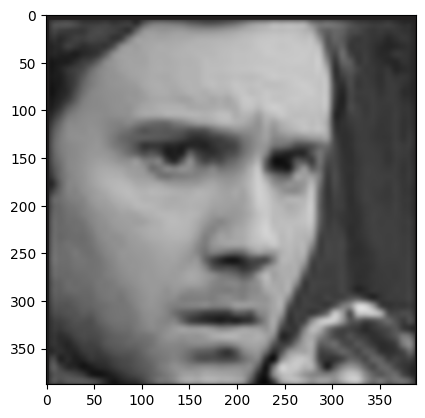

(388, 388, 3)


In [4]:
img = cv2.imread('test_images_internet\\fer_test.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

print(img.shape)

In [5]:
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import matplotlib.pyplot as plt
import drawing_utils_copy


def draw_landmarks_on_image(rgb_image, detection_result, ):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    drawing_utils_copy.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    drawing_utils_copy.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    drawing_utils_copy.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

In [ ]:
def myfunc(i):
    import mediapipe as mp
    from mediapipe.tasks import python
    from mediapipe.tasks.python import vision

    base_options = python.BaseOptions(model_asset_path=model_path_local)
    options = vision.FaceLandmarkerOptions(base_options=base_options,
                                        output_face_blendshapes=True,
                                        output_facial_transformation_matrixes=True,
                                        num_faces=1)
    detector = vision.FaceLandmarker.create_from_options(options)


    image = test_images[i]
    label = test_labels[i]
    emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral', 7: 'Contempt'}
    emotion = np.argmax(label)
    print(emotions[emotion])
    image = np.array(image, dtype=np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = Image.fromarray(image)
    from torchvision import transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224))
    ])

    image = transform(image)

    image = np.array(image, dtype=np.uint8)
    
    plt.imshow(image)
    plt.show()

    # Convert numpy array to Mediapipe Image format
    print(image.shape)
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    # image = mp.Image.create_from_file("C:\\BME\\7_felev\\szakdoli\\code\\ViT-FerPlus\\test_images_internet\\angry_dude.jpg")
    detection_result = detector.detect(image)
    annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
    plt.axis('off')
    plt.imshow(annotated_image)
    plt.show()
    
    return detection_result

Neutral


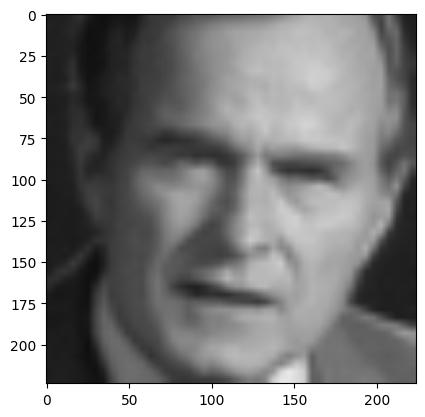

(224, 224, 3)


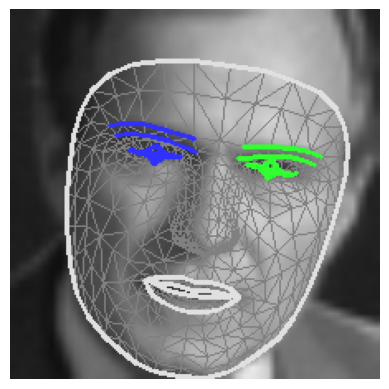

In [18]:
# 524, 865
i = 34
detection_result = myfunc(i)

In [19]:
print(detection_result.face_landmarks)
print(len(detection_result.face_landmarks[0]))

[[NormalizedLandmark(x=0.5031863451004028, y=0.7390516996383667, z=-0.052370551973581314, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5284207463264465, y=0.643424391746521, z=-0.15424306690692902, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5207839608192444, y=0.6652781367301941, z=-0.06996790319681168, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5172984600067139, y=0.5286109447479248, z=-0.13549450039863586, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5331610441207886, y=0.6119858026504517, z=-0.17062418162822723, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5385211110115051, y=0.5670320391654968, z=-0.16630329191684723, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5525943636894226, y=0.45522594451904297, z=-0.1104496642947197, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3370829224586487, y=0.38708484172821045, z=0.005531946197152138, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5614727735519409, y=0.38968902

In [20]:
print(len(detection_result.face_blendshapes[0]))

52


In [21]:
print(detection_result.face_blendshapes[0])

[Category(index=0, score=1.2866041288361885e-05, display_name='', category_name='_neutral'), Category(index=1, score=0.9438031911849976, display_name='', category_name='browDownLeft'), Category(index=2, score=0.935480535030365, display_name='', category_name='browDownRight'), Category(index=3, score=5.467073265208455e-07, display_name='', category_name='browInnerUp'), Category(index=4, score=8.526832971256226e-05, display_name='', category_name='browOuterUpLeft'), Category(index=5, score=9.461858280701563e-05, display_name='', category_name='browOuterUpRight'), Category(index=6, score=0.00018407028983347118, display_name='', category_name='cheekPuff'), Category(index=7, score=3.6293269545240037e-07, display_name='', category_name='cheekSquintLeft'), Category(index=8, score=3.677445477023866e-07, display_name='', category_name='cheekSquintRight'), Category(index=9, score=0.46357399225234985, display_name='', category_name='eyeBlinkLeft'), Category(index=10, score=0.4073292315006256, dis

In [22]:
print(detection_result.face_landmarks[0][0])

NormalizedLandmark(x=0.5031863451004028, y=0.7390516996383667, z=-0.052370551973581314, visibility=0.0, presence=0.0)


In [23]:
from typing import List, Mapping, Optional, Tuple, Union
import math

def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

In [24]:
data = detection_result.face_landmarks[0][0]

print(data)

NormalizedLandmark(x=0.5031863451004028, y=0.7390516996383667, z=-0.052370551973581314, visibility=0.0, presence=0.0)


In [25]:
x = 0.46463075280189514
y = 0.6166279315948486

image_width = 1280
image_height = 720

x_px, y_px = _normalized_to_pixel_coordinates(x, y, image_width, image_height)

print(x_px)
print(y_px)

594
443


In [26]:
image = train_images[314]
label = train_labels[314]

image.shape

(48, 48)

In [27]:
from torch.utils.data import Dataset, DataLoader
class FERP_PreDataset(Dataset):
  def __init__(self, x_face, y_lab, transform):
    super(FERP_PreDataset,self).__init__()
    self.x_face = x_face
    self.y_lab = y_lab
    self.transform = transform 

  def __len__(self):
    return len(self.y_lab)
  
  def __getitem__(self, index):
    image_face = self.x_face[index]
    label = self.y_lab[index]
    
    image_face = np.array(image_face, dtype=np.uint8)
    image_face = cv2.cvtColor(image_face, cv2.COLOR_GRAY2RGB)

    return self.transform(image_face), torch.tensor(label, dtype=torch.float32)

In [30]:
from torchvision import transforms
batch_size = 32

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((224, 224)), ])

train_dataset = FERP_PreDataset(train_images, train_labels, \
                                  train_transform)
val_dataset = FERP_PreDataset(val_images, val_labels, \
                                test_transform)
test_dataset = FERP_PreDataset(test_images, test_labels, \
                                 test_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))

train loader  887 val loader  111 test 112


(119, 137) niose
(224, 224, 3)


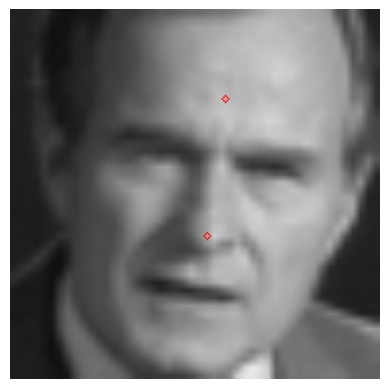

In [35]:
# 153 es 4 a relevans pontok magahoz a szakdolihoz kapcsolodoan

image_width = 224
image_height = 224

image, label = test_dataset[34]

nose_3d = detection_result.face_landmarks[0][4]
nose = _normalized_to_pixel_coordinates(nose_3d.x, nose_3d.y, image_width, image_height)
print(f"{nose} niose")

image = np.array(image)
print(image.shape)
i = 0
for landmark in detection_result.face_landmarks[0]:
    px_coords = _normalized_to_pixel_coordinates(landmark.x, landmark.y, image_width, image_height)
    
    if px_coords is not None:
        x, y = px_coords
        if i == 4:
            cv2.circle(image, (x, y), 2, (0, 0, 255), 1)
        if i == 151:
            cv2.circle(image, (x, y), 2, (0, 0, 255), 1)
        # if i == 128:
        #     print(f"nose top left: {i}")
        #     print(f"{x} {y}")
        #     cv2.circle(image, (x, y), 2, (0, 0, 255), 1)
        # if i == 357:
        #     print(f"top nose right {i}")
        #     print(f"{x} {y}")
        #     cv2.circle(image, (x, y), 2, (0, 0, 255), 1)
        # if i == 423:
        #     print(f"bottom nose right: {i}")
        #     print(f"{x} {y}")
        #     cv2.circle(image, (x, y), 2, (0, 0, 255), 1)
        # if i == 203:
        #     print(f"bottom nose left: {i}")
        #     print(f"{x} {y}")
        #     cv2.circle(image, (x, y), 2, (0, 0, 255), 1)
            
    i += 1
        
image_rgb_with_circle = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(image_rgb_with_circle)
plt.show()

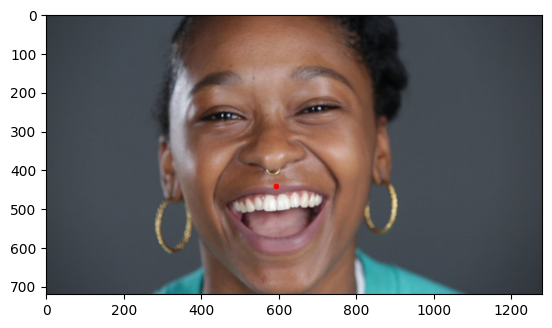

In [ ]:
image_path = "C:\\BME\\7_felev\\szakdoli\\code\\ViT-FerPlus\\test_images_internet\\smiley_woman.jpg"
image_pil = Image.open(image_path)

image_rgb = np.array(image_pil)

image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
cv2.circle(image_bgr, (x_px, y_px), 2, (0, 0, 255), 10)
image_rgb_with_circle = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb_with_circle)
plt.show()

In [ ]:
from PIL import Image, ImageDraw
import math

image_path = "C:\\BME\\7_felev\\szakdoli\\code\\ViT-FerPlus\\test_images_internet\\smiley_woman.jpg"
image = Image.open(image_path)

image_width, image_height = image.size

draw = ImageDraw.Draw(image)

dot_radius = 5
dot_color = (255, 0, 0)

for landmark in detection_result.face_landmarks[0]:
    pixel_coordinates = _normalized_to_pixel_coordinates(
        landmark.x, landmark.y, image_width, image_height
    )
    if pixel_coordinates is not None:
        x_image, y_image = pixel_coordinates
        draw.ellipse(
            (x_image - dot_radius, y_image - dot_radius, x_image + dot_radius, y_image + dot_radius),
            fill=dot_color,
        )
        break

image.show()
# image.save("output_image_with_dots.jpg")
